# data analysis and wrangling


## Imports

In [823]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import ppscore as pps

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


## Load Data

In [824]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [825]:
all_df = pd.concat((train_df.loc[:,'Pclass':'Embarked'], test_df.loc[:,'Pclass':'Embarked'])).reset_index(drop=True)

In [826]:
pd.crosstab(all_df['SibSp'], all_df['Parch'])
ga = all_df[['Parch', 'SibSp', 'Age']].groupby(['Parch','SibSp'], as_index=False).mean()
for x in ga:
    all_df.loc[(all_df.Age.isnull()) & (all_df.Parch == x[0] ) & ( all_df.SibSp == x[1]), 'Age'] = x[2]



In [827]:
all_df['Title'] = all_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(all_df['Title'], all_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [828]:
all_df['Title'] = all_df['Title'].replace(['Mlle', 'Lady', 'Ms', 'Countess', 'Dona'], 'Miss')
all_df['Title'] = all_df['Title'].replace('Mme', 'Mrs')
all_df['Title'] = all_df['Title'].replace(['Sir', 'Major', 'Rev', 'Don', 'Jonkheer'], 'Mr')
all_df['Title'] = all_df['Title'].replace('^(?!.*(Miss|Mrs|Mr|Master)).*$', 'Rare',regex=True)

In [829]:
title_mapping = {"Mr": 1, "Miss": 4, "Mrs": 2, "Master": 3, "Rare": 0}

all_df['Title'] = all_df['Title'].map(title_mapping)
all_df['Title'] = all_df['Title'].fillna(0)

all_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2
2,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,4
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2
4,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1


In [830]:
# arr = all_df.pivot_table(index=['Ticket'], aggfunc='size')
# for x in arr.index:
#      all_df.loc[ all_df['Ticket'] == x, 'Mu1'] = arr.get(x)
    

# all_df['Mu'] = 0
# all_df.loc[(all_df.Ticket.duplicated(keep= False)) , 'Mu'] = 1
# all_df['Mu'] = all_df['Mu'].astype(int)
    
all_df = all_df.drop(['Ticket'], axis=1)
# all_df.head()

In [831]:
all_df = all_df.drop(['Name'], axis=1)

In [832]:
all_df['Sex'] = all_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
all_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,0,22,1,0,7.2500,NaN,S,1
1,1,1,38,1,0,71.2833,C85,C,2
2,3,1,26,0,0,7.9250,NaN,S,4
3,1,1,35,1,0,53.1000,C123,S,2
4,3,0,35,0,0,8.0500,NaN,S,1


## Completing a numerical continuous feature¶


In [833]:
# grid = sns.FacetGrid(train_df, row='Title', col='Sex', size=2.2, aspect=1.6)
# grid.map(plt.hist, 'Age', alpha=.5, bins=20)
# grid.add_legend()

In [834]:
guess_ages = np.zeros((2,5))
guess_ages

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [835]:
all_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,0,22,1,0,7.2500,NaN,S,1
1,1,1,38,1,0,71.2833,C85,C,2
2,3,1,26,0,0,7.9250,NaN,S,4
3,1,1,35,1,0,53.1000,C123,S,2
4,3,0,35,0,0,8.0500,NaN,S,1


In [836]:
for i in range(0,2):
    for j in range(0,5):
        guss_df = all_df[(all_df['Sex'] == i) & (all_df['Title'] == j )]['Age'].dropna()
        guss_age = guss_df.median()
        if guss_age != guss_age:
            guss_age = 0
        guess_ages[i,j] = int(guss_age/0.5 + 0.5) * 0.5
for i in range(0,2):
    for j in range(0,5):
        all_df.loc[(all_df.Age.isnull()) & (all_df.Sex == i ) & ( all_df.Title == j), 'Age'] = guess_ages[i,j]

all_df['Age'] = all_df['Age'].astype(int)
all_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,0,22,1,0,7.2500,NaN,S,1
1,1,1,38,1,0,71.2833,C85,C,2
2,3,1,26,0,0,7.9250,NaN,S,4
3,1,1,35,1,0,53.1000,C123,S,2
4,3,0,35,0,0,8.0500,NaN,S,1


In [837]:
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] <= 18)& (all_df['Sex'] <= 0), 'Title'] = 3
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] <= 18)& (all_df['Sex'] <= 1), 'Title'] = 4
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] > 18)& (all_df['Sex'] <= 1), 'Title'] = 2
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] > 18)& (all_df['Sex'] <= 0), 'Title'] = 1

# all_df = all_df.drop(['Title'], axis=1)

In [838]:
# cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2}

# all_df['Cabin'] = all_df['Cabin'].fillna('U')
# all_df['Cabin'] = all_df['Cabin'].replace('([0-9]+)', '',regex=True).str.slice(0, 1)
# all_df['Cabin'] = all_df['Cabin'].map(cabin_category)
    
all_df = all_df.drop(['Cabin'], axis=1)

In [839]:
freq_port = train_df.Embarked.dropna().mode()[0]
all_df['Embarked'] = all_df['Embarked'].fillna(freq_port)
all_df['Embarked'] = all_df['Embarked'].map( {'S': 0, 'C': 2, 'Q': 1} ).astype(int)

all_df['Pclass'] = all_df['Pclass'].fillna(freq_port)
all_df['Pclass'] = all_df['Pclass'].map( {3: 0, 2: 1, 1: 2} ).astype(int)

In [840]:
# guess_cabins = np.zeros((3,3))
# for i in range(0,3):
#     for j in range(0,3):
#         guess_df = all_df[(all_df['Pclass'] == i) & (all_df['Embarked'] == j)]['Cabin'].dropna()
#         guess_cabin = guess_df.median()
#         guess_cabins[i,j] = int(guess_cabin/0.5 + 0.5) * 0.5
# for i in range(0,3):
#     for j in range(0,3):
#         all_df.loc[(all_df.Cabin.isnull()) & (all_df.Pclass == i ) & ( all_df.Embarked == j), 'Cabin'] = guess_cabins[i,j]

In [841]:
# train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [842]:
all_df.loc[ all_df['Age'] <= 16, 'Age'] = 4
all_df.loc[(all_df['Age'] > 16) & (all_df['Age'] <= 32), 'Age'] = 3
all_df.loc[(all_df['Age'] > 32) & (all_df['Age'] <= 48), 'Age'] = 2
all_df.loc[(all_df['Age'] > 48) & (all_df['Age'] <= 64), 'Age'] = 1
all_df.loc[ all_df['Age'] > 64, 'Age'] = 0

In [843]:
# train_df = train_df.drop(['AgeBand'], axis=1)
# combine = [train_df, test_df]
# train_df.head()

In [844]:
all_df['FamilySize'] = all_df['SibSp'] + all_df['Parch'] + 1

# train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [845]:
# for dataset in combine:
#     dataset['IsAlone'] = 0
#     dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [846]:
all_df = all_df.drop(['Parch', 'SibSp'], axis=1)

In [847]:
all_df['Age*Class'] = all_df.Sex + all_df.Pclass + 1

In [848]:
freq_port = train_df.Embarked.dropna().mode()[0]

In [849]:
all_df['E*P'] =  all_df.Pclass + all_df.Embarked + 1

In [850]:
all_df['Fare'].fillna(all_df['Fare'].dropna().median(), inplace=True)
# all_df = all_df.drop(['Fare'], axis=1)

In [851]:
# train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
# train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

In [852]:
all_df.loc[ all_df['Fare'] <= 7.91, 'Fare'] = 0
all_df.loc[(all_df['Fare'] > 7.91) & (all_df['Fare'] <= 14.454), 'Fare'] = 1
all_df.loc[(all_df['Fare'] > 14.454) & (all_df['Fare'] <= 31), 'Fare']   = 2
all_df.loc[ all_df['Fare'] > 31, 'Fare'] = 3
all_df['Fare'] = all_df['Fare'].astype(int)

# all_df = all_df.drop(['Fare'], axis=1)

In [853]:
all_df['Sex*Fare'] = all_df.Sex + all_df.Fare + 1

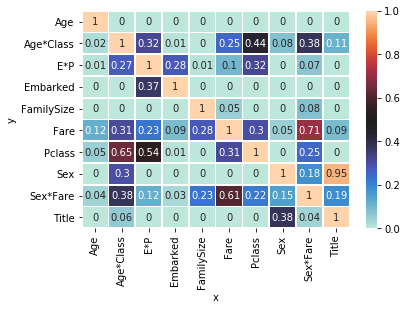

In [854]:
matrix_pps = pps.matrix(all_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_pps = matrix_pps.apply(lambda x: round(x, 2))

sns.heatmap(matrix_pps, vmin=0, vmax=1, cmap="icefire", linewidths=0.75, annot=True)

In [855]:
# dummy_col=[ 'Age', 'Embarked', 'Pclass',  'Fare', 'FamilySize', 'Title', 'E*P', 'Age*Class']

# dummy = pd.get_dummies(all_df[dummy_col], columns=dummy_col, drop_first=False)
# all_df = pd.concat([dummy,  all_df['Sex']], axis = 1)
# all_df = dummy
# all_df

In [856]:
Y_train = train_df["Survived"]
pass_temp = test_df['PassengerId']
train_df = all_df[:train_df.shape[0]]
test_df = all_df[train_df.shape[0]:] 

In [857]:
x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_df[:] = x_scaled

x = test_df.values 

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test_df[:] = x_scaled
train_df.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,Age*Class,E*P,Sex*Fare
0,0.0,0.0,0.75,0.000000,0.0,0.000000,0.1,0.000000,0.0,0.00
1,1.0,1.0,0.50,1.000000,1.0,0.333333,0.1,1.000000,1.0,1.00
2,0.0,1.0,0.75,0.333333,0.0,1.000000,0.0,0.333333,0.0,0.50
3,1.0,1.0,0.50,1.000000,0.0,0.333333,0.1,1.000000,0.5,1.00
4,0.0,0.0,0.50,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.25


## Model, predict and solve


In [858]:
X_train = train_df
X_test  = test_df
X_train.shape, Y_train.shape, X_test.shape


((891, 10), (891,), (418, 10))

In [859]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)
Y_pred_logreg.astype(int)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.79

In [860]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Age,1.585307
2,Fare,1.356449
7,E*P,1.077567
5,FamilySize,0.858309
0,Sex,0.823697
8,Sex*Fare,0.512644
4,Title,0.201591
3,Embarked,0.185637
6,Age*Class,-1.897520


In [861]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
Y_pred_svc = Y_pred.astype(int)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.16

In [862]:
knn = KNeighborsClassifier(n_neighbors = 35)
knn.fit(X_train, Y_train)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
Y_pred = knn.predict(X_test)
Y_pred_knn = Y_pred.astype(int)
acc_knn

81.82

In [863]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
Y_pred_gaussian = Y_pred.astype(int)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.21

In [864]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
Y_pred_perceptron = Y_pred.astype(int)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.91

In [865]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
Y_pred_linear_svc = Y_pred.astype(int)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.01

In [866]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
Y_pred_sgd = Y_pred.astype(int)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

79.69

In [867]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
Y_pred_decision_tree = Y_pred.astype(int)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

88.66

In [868]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
Y_pred = Y_pred.astype(int)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

88.66

In [869]:
MLP = MLPClassifier(random_state=1, max_iter=300 )
MLP.fit(X_train, Y_train)
Y_pred = MLP.predict(X_test)
Y_pred_MLP = Y_pred.astype(int)
MLP.score(X_train, Y_train)
acc_MLP = round(MLP.score(X_train, Y_train) * 100, 2)
acc_MLP

83.39

In [870]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])
X_train = X_train.astype(float)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train.values, Y_train.values, epochs=25) 
Y_pred_r = model.predict(X_test)
Y_pred_kr = Y_pred_r.astype(int)             

Train on 891 samples
Epoch 1/25
891/891 [==============================] - 0s 341us/sample - loss: 0.5249 - accuracy: 0.7666
Epoch 2/25
891/891 [==============================] - 0s 95us/sample - loss: 0.4518 - accuracy: 0.7980
Epoch 3/25
891/891 [==============================] - 0s 95us/sample - loss: 0.4255 - accuracy: 0.8193
Epoch 4/25
891/891 [==============================] - 0s 98us/sample - loss: 0.4199 - accuracy: 0.8294
Epoch 5/25
891/891 [==============================] - 0s 92us/sample - loss: 0.4181 - accuracy: 0.8260
Epoch 6/25
891/891 [==============================] - 0s 91us/sample - loss: 0.4092 - accuracy: 0.8238
Epoch 7/25
891/891 [==============================] - 0s 92us/sample - loss: 0.4099 - accuracy: 0.8316
Epoch 8/25
891/891 [==============================] - 0s 93us/sample - loss: 0.4044 - accuracy: 0.8283
Epoch 9/25
891/891 [==============================] - 0s 80us/sample - loss: 0.3856 - accuracy: 0.8316
Epoch 10/25
891/891 [==============================

In [871]:
# 
Y_pred_r = np.zeros(len(Y_pred_r))
Y_pred_all = np.array([Y_pred_MLP,  Y_pred_svc, Y_pred_knn, Y_pred_decision_tree, Y_pred_sgd ]).transpose()
for  index, x in enumerate(Y_pred_all):
    Y_pred_r[index] = np.bincount(x).argmax()
Y_pred_r = Y_pred_r.astype(int)
# Y_pred_all.shape

In [872]:
    models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'MLP'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_MLP]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,88.66
8,Decision Tree,88.66
9,MLP,83.39
0,Support Vector Machines,83.16
1,KNN,81.82
5,Perceptron,79.91
6,Stochastic Gradient Decent,79.69
7,Linear SVC,79.01
2,Logistic Regression,78.79
4,Naive Bayes,76.21


In [873]:
submission = pd.DataFrame({
        "PassengerId": pass_temp,
        "Survived": Y_pred_r
    })
submission.to_csv('../out/submission.csv', index=False)